## Association between gene expression and subtype or grade
### (Brain Lower Grade Glioma) 

In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

## Gene Data Preprocessing

In [89]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,8.7141,36.4493,11.8131,8.6116,0.000,5.3382,3.7845,8.3071,...,19.1299,12.5770,10.9796,7.8225,3.3371,5.4526,8.2616,11.5121,5.3895,9.9433
2,UBE2Q2P2,100134869,22.7523,21.1767,11.0242,5.0835,30.261,27.8886,8.7230,15.4466,...,21.9905,27.0125,14.2608,16.6975,10.2310,16.1890,19.7074,18.7291,8.9103,7.4480


In [90]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail(3)

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [91]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 514 samples in total, and there are 20531 genes in total.


In [6]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: False
There are 307 columns with the same value.
[136542, 317712, 728045, 728036, 255313, 728096, 728062, 653282, 728042, 57135]...


In [92]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean.drop(same_value_cols, axis = 1)

normalizing counts per cell
    finished (0:00:00)


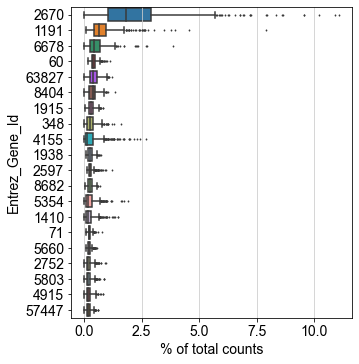

In [13]:
adata_gene = sc.AnnData(df_clean_1)
sc.pl.highest_expr_genes(adata_gene, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

## Clinical Patient Data Preprocessing

In [17]:
## read patient data and preprocessing...
raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

## Creating anndata with sample as its obs:

In [76]:
df_sample_with_gene = df_clean_1.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [77]:
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [80]:
sc.tl.pca(adata_sample, svd_solver = "arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


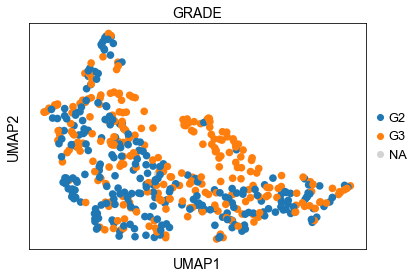

In [84]:
sc.pp.neighbors(adata_sample, n_neighbors=5)
sc.tl.umap(adata_sample, min_dist=0.3)
sc.pl.umap(adata_sample, color = ["GRADE"])

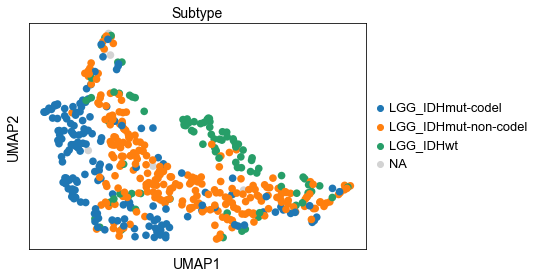

In [85]:
sc.pl.umap(adata_sample, color = ["Subtype"])

## TCGA researchers learned about lower grade glioma?

Reference: https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/glioma

Mutations and chromosomal alterations define three lower grade glioma subtypes with distinct clinical outcomes: 

1. IDH mutant and 1p/19q co-deletion:

* The 1p/19q abnormality consists of deletion of a short arm of chromosome 1 and longer arm of chromosome 19.

* Mutations in IDH1 and IDH2, isocitrate dehydrogenases, lead to abnormal enzyme activity, hypermethylation, and deviant gene expression.

* This subtype is associated with the most favorable prognosis.

2. IDH mutant without 1p/19q co-deletion, associated with intermediate prognosis



3. IDH wild-type, associated with the poorest outcomes

IDH wild-type subtype shares genomic markers and similar clinical outcomes with glioblastomas, indicating that this subtype of lower grade glioma may be a precursor to the more aggressive counterpart.


Molecular signatures and subtypes may inform the classification, diagnosis, and treatment of lower grade gliomas:

* Lower grade gliomas without IDH mutations may benefit from treatment with protocols adapted from current glioblastoma treatments.

* Recently developed therapies may target the aberrant activity of IDH1/2 proteins in lower grade glioma.


In [74]:
gene_symbol_id.loc[(gene_symbol_id.Hugo_Symbol == "IDH1") | (gene_symbol_id.Hugo_Symbol == "IDH2")]

,Hugo_Symbol,Entrez_Gene_Id
8233,IDH1,3417
8234,IDH2,3418


## Association between glioma subtype and gene expression? 

**Summary:**  

According to following models, we found that gene expression level would have highly correlation with the subtype of Brain Lower Grade Glioma. We could predict the subtype of BLGG based on the level of expression. 

In [46]:
# preprocessing the data: encode, drop nan, scale? 
X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

In [47]:
df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

In [48]:
# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [50]:
print(f"There are totally {len(X_test)} samples in test set.")

There are totally 127 samples in test set.


In [40]:
# using random forest classifier as the predicting model: 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(warm_start = True, n_estimators = 100)
rf.fit(X_train,y_train)
print(f"The training set accuracy score: {rf.score(X_train,y_train)}")
print(f"The test set accuracy score: {rf.score(X_test,y_test)}")

The training set accuracy score: 1.0
The test set accuracy score: 0.984251968503937


In [40]:
# F1-score, precision & recall 
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        42

    accuracy                           0.98       127
   macro avg       0.99      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127



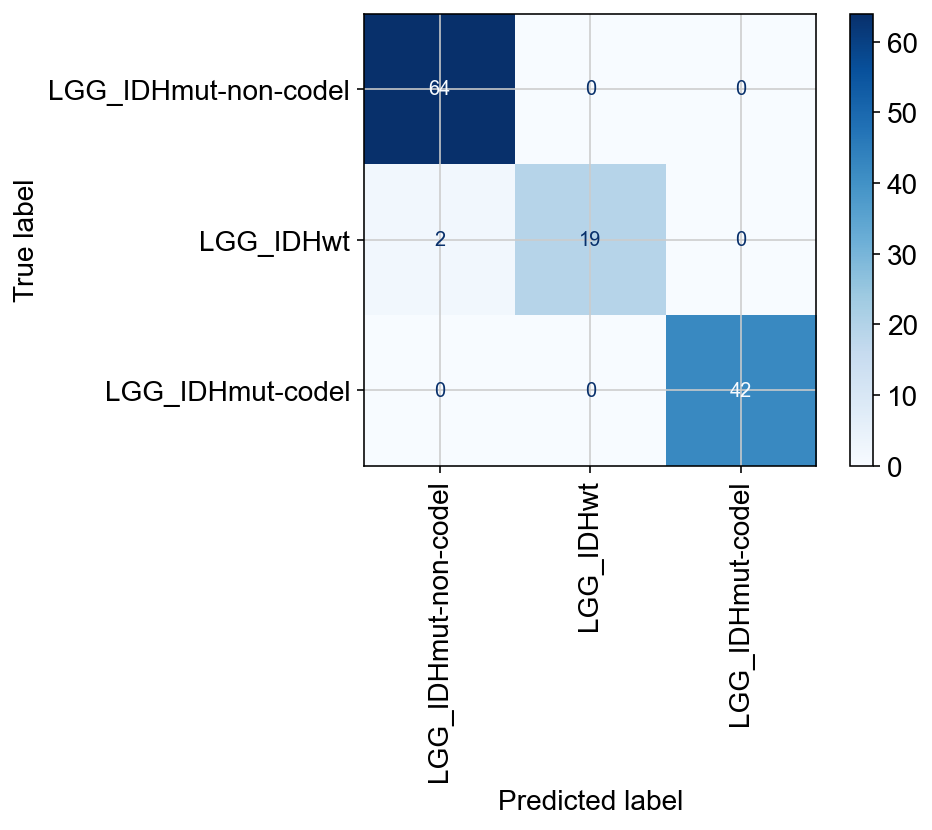

In [41]:
# confusion matrix 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
disp = plot_confusion_matrix(rf, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

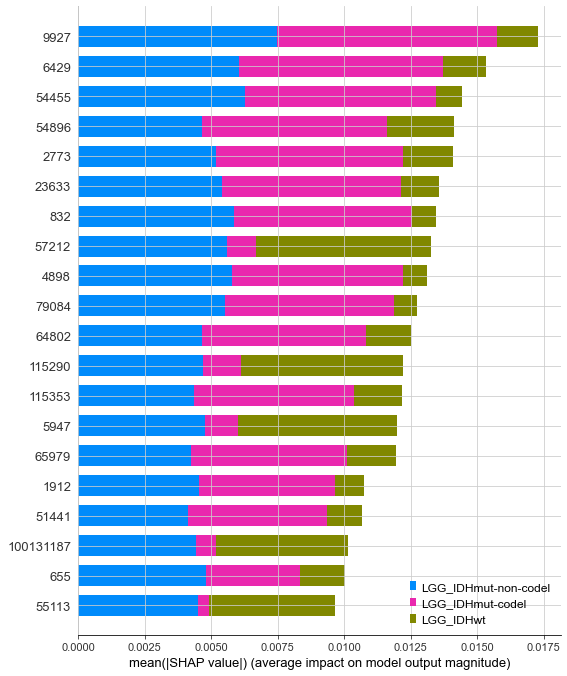

In [71]:
# feature importance inspection 
import shap 
explainer = shap.TreeExplainer(rf)
shap_valuesfor = explainer.shap_values(X)

class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_valuesfor, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

## Reduce the # features to 100 genes and build the model again: 

In [51]:
from sklearn.feature_selection import SelectKBest,f_regression

select = SelectKBest(k=100, score_func = f_regression)
select.fit(X_train, y_train)
selected_genes = X.columns[select.get_support(indices=True)]

In [52]:
X_selected = X[selected_genes].copy()
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_selected,y,random_state = 42)
# using random forest classifier as the predicting model: 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(warm_start = True, n_estimators = 100)
rf.fit(X_train,y_train)
print(f"100 selected features: The training set accuracy score: {rf.score(X_train,y_train)}")
print(f"100 selected features: The test set accuracy score: {rf.score(X_test,y_test)}")
# F1-score, precision & recall 
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

100 selected features: The training set accuracy score: 1.0
100 selected features: The test set accuracy score: 0.968503937007874
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.95      0.86      0.90        21
           2       1.00      1.00      1.00        42

    accuracy                           0.97       127
   macro avg       0.97      0.95      0.96       127
weighted avg       0.97      0.97      0.97       127



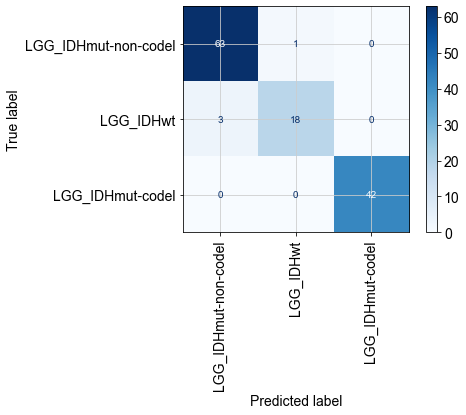

In [53]:
# confusion matrix 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
disp = plot_confusion_matrix(rf, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

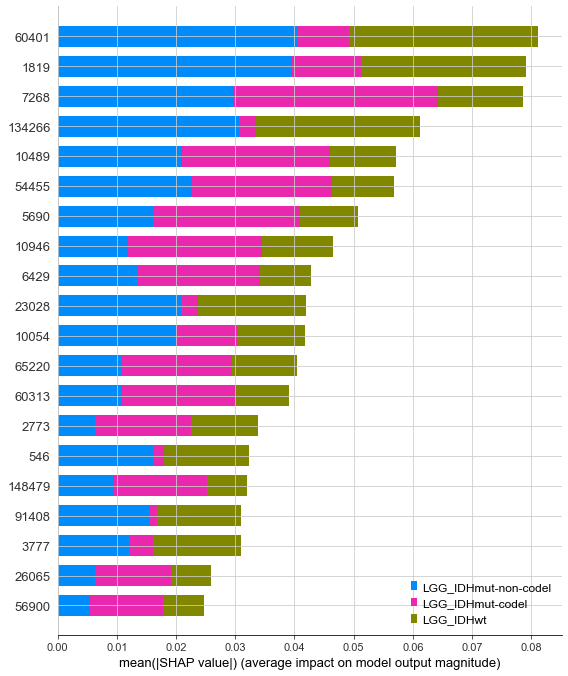

In [55]:
# feature importance inspection 
import shap 
explainer = shap.TreeExplainer(rf)
shap_valuesfor = explainer.shap_values(X_selected)

class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_valuesfor, X_selected.values, plot_type="bar", class_names= class_names, feature_names = X_selected.columns)

## Gene clustering 
Compared two SHAP plots, found two models have different features in top rank. There might be some similarities in gene in expression. I am trying to assign genes into different groups as different metagenes with clustering methods and Non-negative Matrix Factorization, and plan to do hypothesis testing for the difference between subtypes for each subtype.

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


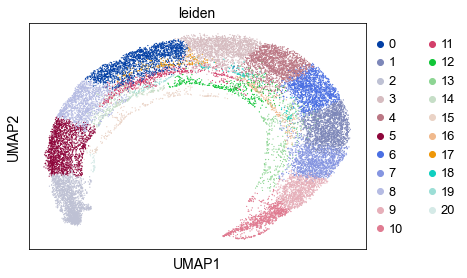

In [62]:
# can I use umap to cluster genes? 
df_gene = df_clean_1.transpose()
adata_gene = sc.AnnData(df_gene)
sc.tl.pca(adata_gene, svd_solver='arpack')
sc.pp.neighbors(adata_gene, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_gene, min_dist=0.3)
sc.tl.leiden(adata_gene)
sc.pl.umap(adata_gene, color = "leiden")

In [65]:
df_gene_cluster = adata_gene.obs
df_gene_cluster.groupby('leiden').leiden.count()

leiden
0     1933
1     1927
2     1900
3     1844
4     1822
5     1776
6     1591
7     1417
8     1375
9     1083
10     972
11     568
12     402
13     387
14     305
15     256
16     217
17     202
18     116
19      92
20      39
Name: leiden, dtype: int64

In [ ]:
## NMF ... 
## .......

In [ ]:
## Censensus clustering for gene??

## Grade & Gene ? 

In [56]:
## preprocessing the data: encode, drop nan, scale? 
X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['GRADE']
df = pd.concat([X,y], axis = 1)
df_drop = df.drop(df[df.GRADE.isnull()].index, axis = 0)
print(f"Dropping {len(df[df.GRADE.isnull()])} samples without GRADE")
# assign features, target and encoding...
y = df_drop["GRADE"]
X= df_drop.drop("GRADE", axis = 1)

y = y.map({"G2":0, "G3":1})

Dropping 2 samples without GRADE


In [57]:
from sklearn.feature_selection import SelectKBest,f_regression

select = SelectKBest(k=10, score_func = f_regression)
select.fit(X_train, y_train)
selected_genes = X.columns[select.get_support(indices=True)]
print(f"selected genes are {selected_genes}")

selected genes are Index([280660, 441362, 653553, 29974, 144568, 53947, 51166, 9625, 5244, 4363], dtype='object')


In [58]:
X_selected = X[selected_genes].copy()
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_selected,y,random_state = 42)
# using random forest classifier as the predicting model: 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(warm_start = True, n_estimators = 100)
rf.fit(X_train,y_train)
print(f"400 selected features: The training set accuracy score: {rf.score(X_train,y_train)}")
print(f"400 selected features: The test set accuracy score: {rf.score(X_test,y_test)}")
# F1-score, precision & recall 
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

400 selected features: The training set accuracy score: 1.0
400 selected features: The test set accuracy score: 0.6953125
              precision    recall  f1-score   support

           0       0.62      0.79      0.70        57
           1       0.79      0.62      0.69        71

    accuracy                           0.70       128
   macro avg       0.71      0.70      0.70       128
weighted avg       0.71      0.70      0.70       128



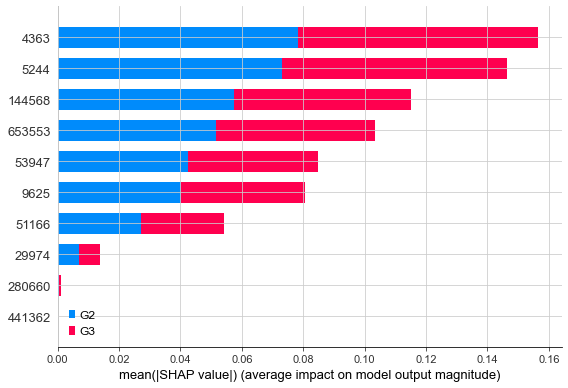

In [60]:
# feature importance inspection 
import shap 
explainer = shap.TreeExplainer(rf)
shap_valuesfor = explainer.shap_values(X_selected)

class_names = ["G2", "G3"]
shap.summary_plot(shap_valuesfor, X_selected.values, plot_type="bar", class_names= class_names, feature_names = X_selected.columns)